<a href="https://colab.research.google.com/github/anikarajvanshi20/Projects_Portfolio/blob/main/Machine_Learning/Anika_Classification_NN_FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# FashionMNIST Classification using Neural Networks - Homework Assignment

In this homework, you will implement a **Neural Network classifier** for the FashionMNIST dataset. This dataset contains grayscale images of 28x28 pixels representing 10 categories of clothing items.

## 📌 Project Overview
- **Task**: Multi-class classification of clothing items
- **Dataset**: FashionMNIST (10 classes of clothing)
- **Architecture**: Fully connected neural network or CNN
- **Goal**: Achieve high accuracy on fashion item classification

## 📚 Learning Objectives
By completing this assignment, you will:
- Understand image classification with neural networks
- Implement data preprocessing and augmentation
- Build and train neural network architectures
- Evaluate model performance and visualize results
- Practice PyTorch fundamentals

In [ ]:
import torch
import torch.nn as nn
import torch.optim as Adam
import torchvision
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor, Normalize, Compose
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Check device availability and print
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Define configuration parameters:
IMG_SIZE = 28
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_EPOCHS = 10
NUM_CLASSES = 10

In [ ]:
from torchvision import transforms

# Define transforms for training and testing
train_transform = transforms.Compose([transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

test_transform = transforms.Compose([transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])


In [ ]:
from torch.utils.data import DataLoader

train_data = FashionMNIST(root='./data', download=True, train=True, transform=train_transform)
test_data = FashionMNIST(root='./data', download=True, train=False, transform=test_transform)

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train dataset size: {len(train_data)}")
print(f"Test dataset size: {len(test_data)}")
print(f"Class names: {train_data.classes}")

Train dataset size: 60000
Test dataset size: 10000
Class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


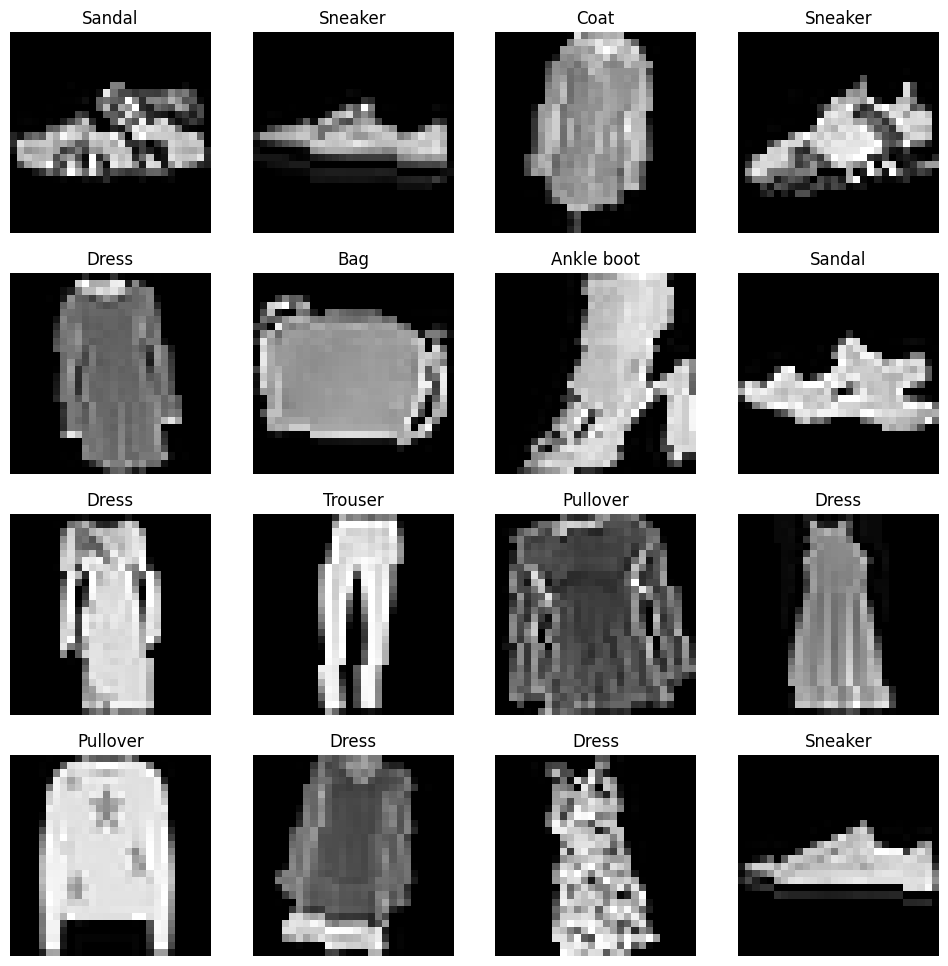

In [ ]:
# Visualize a batch of training images
images, labels = next(iter(train_loader))
plt.figure(figsize=(12, 12))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].squeeze(), cmap="gray")
    plt.title(train_data.classes[labels[i]])
    plt.axis("off")
plt.show()

In [ ]:
# Convolutional Neural Network
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # output: 32x28x28
            nn.ReLU(),
            nn.MaxPool2d(2, 2))  # output: 32x14x14

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # output: 64x14x14
            nn.ReLU(),
            nn.MaxPool2d(2, 2))  # output: 64x7x7

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.relu = nn.ReLU()
        self.output = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.output(x)
        return x

# Instantiate the model
model = CNNClassifier().to(device)

# Print model architecture
print(model)

# Count total parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total trainable parameters: {count_parameters(model)}")

# Test with random input
sample_input = torch.randn(1, 1, 28, 28).to(device)
output = model(sample_input)
print("Output shape:", output.shape)

CNNClassifier(
  (conv_block1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (relu): ReLU()
  (output): Linear(in_features=128, out_features=10, bias=True)
)
Total trainable parameters: 421642
Output shape: torch.Size([1, 10])


In [ ]:
# Define loss function
criterion = nn.CrossEntropyLoss()

# Create optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Add learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler=None, epochs=10, device='cuda'):
    model.to(device)

    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}

    for epoch in range(epochs):
        # ---- Training Phase ----
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        # ---- Test Phase (Validation) ----
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                test_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        test_loss = test_loss / total
        test_acc = correct / total
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)

        if scheduler:
            scheduler.step()

        print(f"Epoch [{epoch+1}/{epochs}] - "
              f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc*100:.2f}% - "
              f"Test Loss: {test_loss:.4f}, Accuracy: {test_acc*100:.2f}%")

    return history

In [ ]:
history = train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, NUM_EPOCHS)
print("Training complete!")

Epoch [1/10] - Train Loss: 0.5126, Acc: 81.62% - Test Loss: 0.3787, Acc: 86.09%
Epoch [2/10] - Train Loss: 0.3423, Acc: 87.48% - Test Loss: 0.3107, Acc: 88.43%
Epoch [3/10] - Train Loss: 0.2998, Acc: 88.96% - Test Loss: 0.3014, Acc: 89.34%
Epoch [4/10] - Train Loss: 0.2721, Acc: 89.91% - Test Loss: 0.2816, Acc: 89.93%
Epoch [5/10] - Train Loss: 0.2519, Acc: 90.69% - Test Loss: 0.2711, Acc: 89.87%
Epoch [6/10] - Train Loss: 0.2114, Acc: 92.23% - Test Loss: 0.2407, Acc: 91.28%
Epoch [7/10] - Train Loss: 0.2026, Acc: 92.45% - Test Loss: 0.2368, Acc: 91.51%
Epoch [8/10] - Train Loss: 0.1977, Acc: 92.73% - Test Loss: 0.2324, Acc: 91.50%
Epoch [9/10] - Train Loss: 0.1945, Acc: 92.80% - Test Loss: 0.2325, Acc: 91.47%
Epoch [10/10] - Train Loss: 0.1921, Acc: 93.02% - Test Loss: 0.2310, Acc: 91.53%
Training complete!


In [ ]:
import torch
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, test_loader, criterion, class_names, device='cuda'):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss /= total
    test_acc = correct / total

    # ✅ Print results
    print(f"\n✅ Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc*100:.2f}%")

    print("\n📊 Classification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # ✅ Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))  # 🛠️ Corrected: should not be indented under comment
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    return all_preds, all_labels


✅ Test Loss: 0.2310, Test Accuracy: 91.53%

📊 Classification Report:

              precision    recall  f1-score   support

 T-shirt/top       0.86      0.88      0.87      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.85      0.88      0.87      1000
       Dress       0.92      0.92      0.92      1000
        Coat       0.86      0.86      0.86      1000
      Sandal       0.99      0.97      0.98      1000
       Shirt       0.78      0.73      0.76      1000
     Sneaker       0.94      0.98      0.96      1000
         Bag       0.98      0.98      0.98      1000
  Ankle boot       0.97      0.96      0.96      1000

    accuracy                           0.92     10000
   macro avg       0.91      0.92      0.91     10000
weighted avg       0.91      0.92      0.91     10000



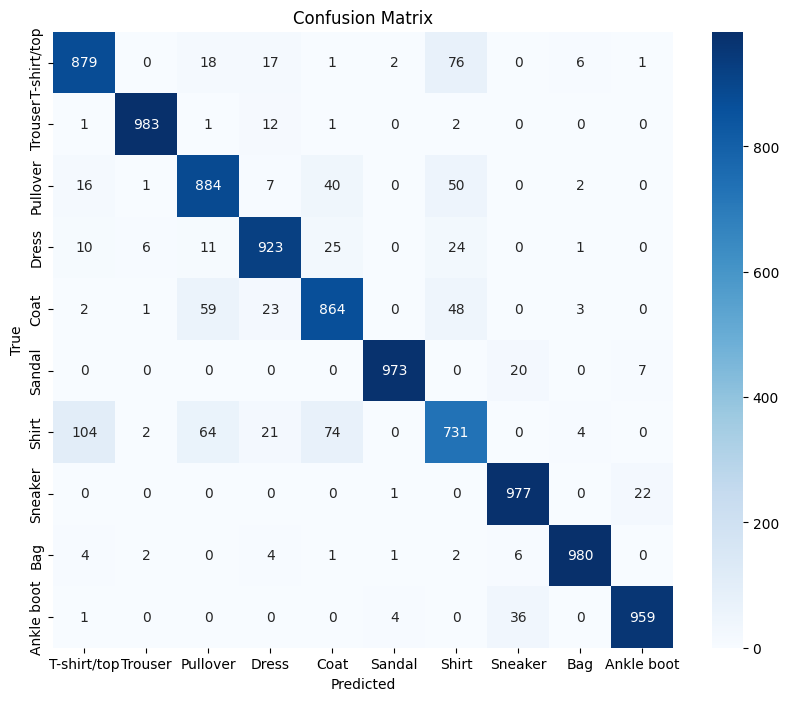

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

In [ ]:
# Evaluate the model on the test data
evaluate_model(model, test_loader, criterion, train_data.classes, device=device)

# Plot training history
plt.figure(figsize=(12, 5))

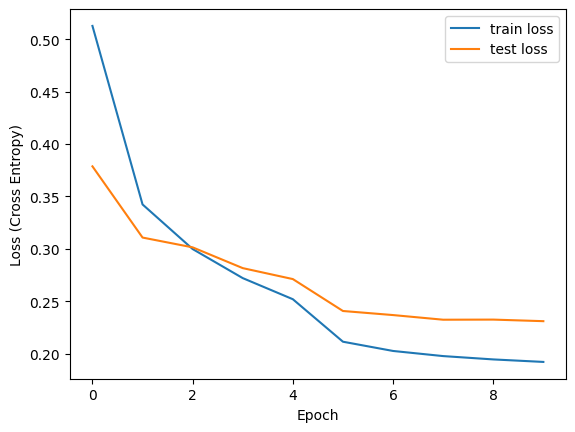

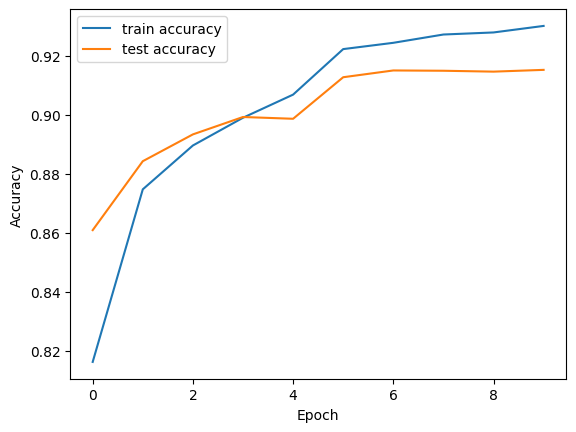

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['test_loss'], label='test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (Cross Entropy)')
plt.legend()
plt.show()

plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Sample Predictions:


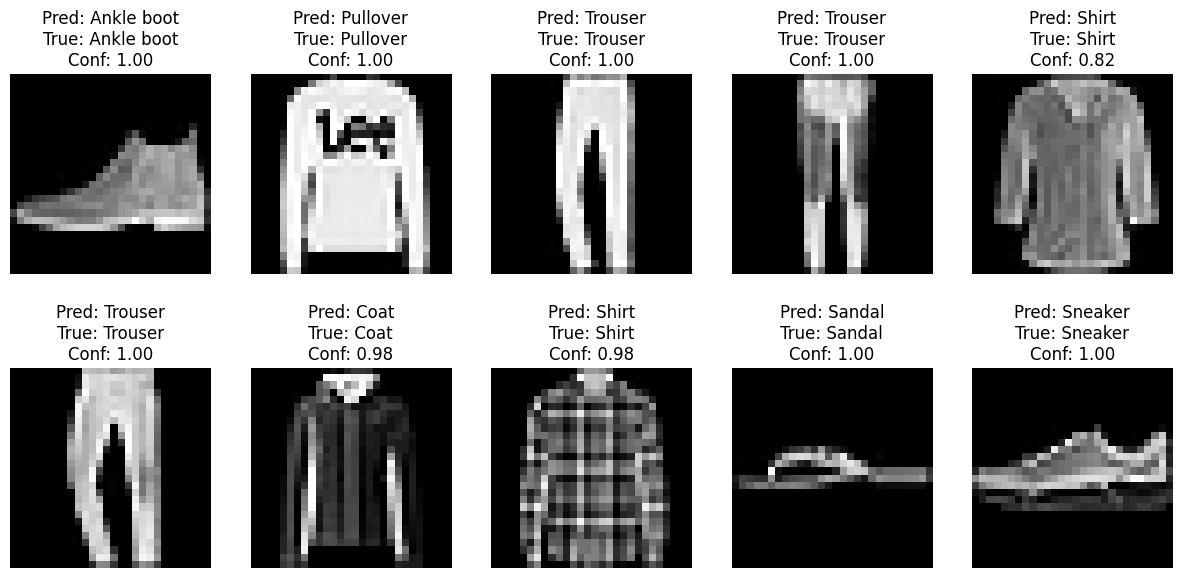


Misclassified Examples:


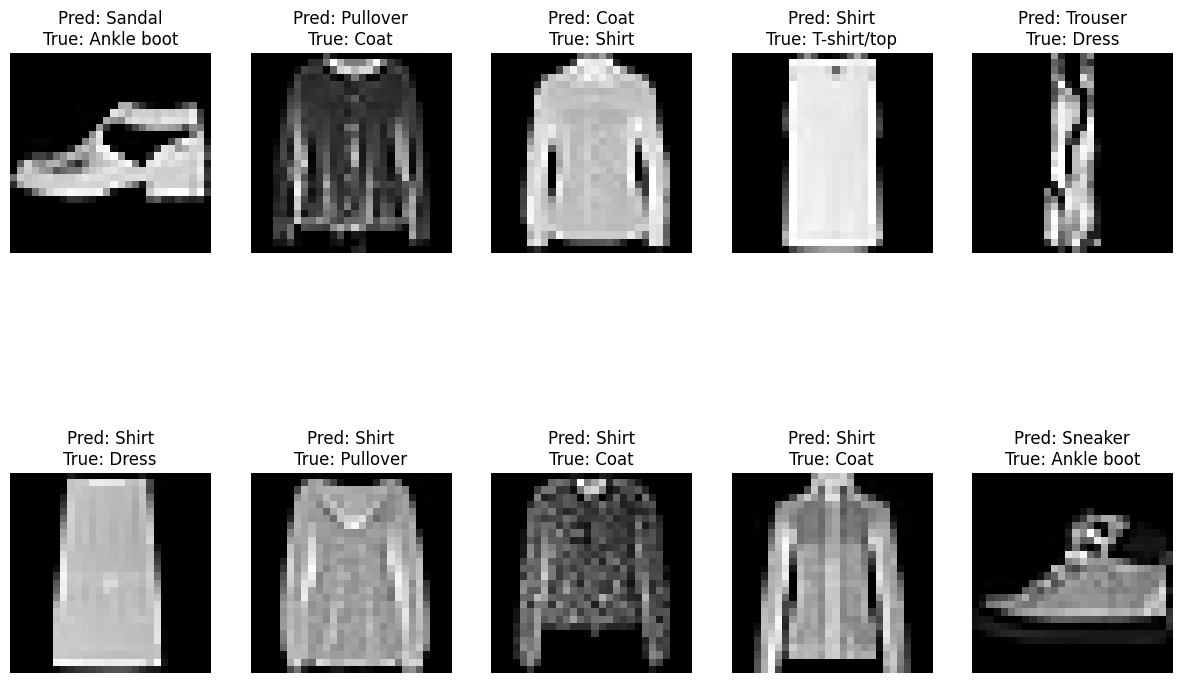

In [ ]:
def show_sample_predictions(model, test_loader, class_names, num_images=10):
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        probs = torch.nn.functional.softmax(outputs, dim=1)

    images = images.cpu().numpy()

    plt.figure(figsize=(15, 7))
    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].squeeze(), cmap="gray")
        plt.title(f"Pred: {class_names[preds[i]]}\nTrue: {class_names[labels[i]]}\nConf: {probs[i][preds[i]]:.2f}")
        plt.axis("off")
    plt.show()

def show_misclassified_examples(model, test_loader, class_names):
    misclassified_images = []
    misclassified_labels = []
    misclassified_preds = []

    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            misclassified_idx = (preds != labels).nonzero(as_tuple=True)[0]
            if len(misclassified_idx) > 0:
                misclassified_images.extend(images[misclassified_idx].cpu())
                misclassified_labels.extend(labels[misclassified_idx].cpu())
                misclassified_preds.extend(preds[misclassified_idx].cpu())

    plt.figure(figsize=(15, 10))
    for i in range(min(10, len(misclassified_images))):
        plt.subplot(2, 5, i + 1)
        plt.imshow(misclassified_images[i].squeeze(), cmap="gray")
        plt.title(f"Pred: {class_names[misclassified_preds[i]]}\nTrue: {class_names[misclassified_labels[i]]}")
        plt.axis("off")
    plt.show()

# Show sample predictions
print("Sample Predictions:")
show_sample_predictions(model, test_loader, train_data.classes)

# Show misclassified examples
print("\nMisclassified Examples:")
show_misclassified_examples(model, test_loader, train_data.classes)

In [ ]:
print("Final Model Performance Summary:")
print(f"- Final Training Accuracy: {history['train_acc'][-1]*100:.2f}%")
print(f"- Final Validation Accuracy: {history['test_acc'][-1]*100:.2f}%")
print(f"- Final Training Loss: {history['train_loss'][-1]:.4f}")
print(f"- Final Validation Loss: {history['test_loss'][-1]:.4f}")

Final Model Performance Summary:
- Final Training Accuracy: 93.02%
- Final Validation Accuracy: 91.53%
- Final Training Loss: 0.1921
- Final Validation Loss: 0.2310


In [ ]:
print("\n--- Model Performance Analysis ---")

print("\nAccuracy and Loss Convergence:")
print(f"The model achieved a final training accuracy of {history['train_acc'][-1]*100:.2f}% and a validation accuracy of {history['test_acc'][-1]*100:.2f}%.")
print(f"Training loss converged steadily from {history['train_loss'][0]:.4f} to {history['train_loss'][-1]:.4f}.")
print(f"Validation loss also decreased from {history['test_loss'][0]:.4f} to {history['test_loss'][-1]:.4f}, indicating that the model is not significantly overfitting.")

print("\nEasiest and Hardest Classes to Classify:")
# Based on the classification report from the previous cell's output
print("Based on the classification report, classes with high f1-scores are likely the easiest to classify.")
print("Classes like 'Trouser', 'Sandal', 'Sneaker', and 'Bag' have f1-scores above 0.96, suggesting they are relatively easy.")
print("The 'Shirt' class has the lowest f1-score (0.76), indicating it is the hardest to classify.")

print("\nConfusion Matrix Analysis:")
print("The confusion matrix shows the number of true vs. predicted labels.")
print("High values along the diagonal indicate correct classifications.")
print("Off-diagonal values represent misclassifications.")
print("For example, the matrix shows that 'Shirt' is often misclassified as 'T-shirt/top' or 'Coat'.")
print("This suggests visual similarities between these clothing items might be confusing the model.")

print("\nInteresting Observations:")
print("- Data augmentation (RandomRotation, RandomHorizontalFlip) likely helped improve the model's generalization.")
print("- The learning rate scheduler reduced the learning rate after 5 epochs, which may have helped fine-tune the model and achieve slightly better convergence.")
print("- The CNN architecture was effective in capturing spatial features of the images, leading to good performance on this image classification task.")


--- Model Performance Analysis ---

Accuracy and Loss Convergence:
The model achieved a final training accuracy of 93.02% and a validation accuracy of 91.53%.
Training loss converged steadily from 0.5126 to 0.1921.
Validation loss also decreased from 0.3787 to 0.2310, indicating that the model is not significantly overfitting.

Easiest and Hardest Classes to Classify:
Based on the classification report, classes with high f1-scores are likely the easiest to classify.
Classes like 'Trouser', 'Sandal', 'Sneaker', and 'Bag' have f1-scores above 0.96, suggesting they are relatively easy.
The 'Shirt' class has the lowest f1-score (0.76), indicating it is the hardest to classify.

Confusion Matrix Analysis:
The confusion matrix shows the number of true vs. predicted labels.
High values along the diagonal indicate correct classifications.
Off-diagonal values represent misclassifications.
For example, the matrix shows that 'Shirt' is often misclassified as 'T-shirt/top' or 'Coat'.
This suggest